# Рынок заведений общественного питания Москвы


СПРИНТ 9

<a name="title"></a>
### Содержание

[Описание проекта](#info)
1. [Подготовка данных](#preprocessing)
  - [Предобработка](#null)
  - [Добавление данных](#data_add) 
2. [Анализ данных](#analitika)
  - [Виды и форматы объектов, их характеристики](#by_param)
  - [Расположение и его влияние](#by_geo)
3. [Общий вывод](#general)

<a name="info"></a>
# Описание проекта

Необходимо подготовить исследование рынка. У нас есть открытые данные о заведениях общественного питания в Москве.

Требуется подготовить презентацию исследования для инвесторов: общий вывод и рекомендации о **виде заведения, количестве посадочных мест, а также районе расположения**. Оценить возможность развития сети.

### Описание данных
Таблица rest_data:

    id — идентификатор объекта;
    object_name — название объекта общественного питания;
    chain — сетевой ресторан;
    object_type — тип объекта общественного питания;
    address — адрес;
    number — количество посадочных мест.
    



[к содержанию...](#title)

 <a name="preprocessing"></a>
# 1. Подготовка данных

<a name="null"></a>
## Предобработка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO
import requests
import re

sns.set_style("ticks") 


Загрузим датасет, оценим структуру и качество данных:

In [2]:
df = pd.read_csv('/datasets/rest_data.csv')

In [3]:
df.sample(10)

,id,object_name,chain,object_type,address,number
547,25469,Москафе,нет,ресторан,"город Москва, Ленинградский проспект, дом 24",70
12813,194975,Кафе «ДжиДжиГриль»,нет,кафе,"город Москва, 1-й Лучевой просек, дом 1",50
7558,150427,Бургер Кинг,да,предприятие быстрого обслуживания,"город Москва, Варшавское шоссе, дом 153",40
9326,167288,Кафе Здоровая еда,нет,кафе,"город Москва, Пресненская набережная, дом 8, с...",20
1553,27693,Арт-столовая,нет,столовая,"город Москва, Курсовой переулок, дом 8/2",60
6330,29626,ШКОЛА 15,нет,столовая,"город Москва, Херсонская улица, дом 27А",30
13801,214623,Кантина (закрытое),нет,столовая,"город Москва, улица Большая Якиманка, дом 24",52
10267,184079,Ночной Баку,нет,кафе,"город Москва, Даниловская набережная, дом 2, к...",60
4610,26236,Кавали клуб,нет,кафе,"город Москва, Совхозная улица, дом 3, строение 2",45
2049,124986,Пицерия,нет,кафе,"город Москва, улица Бахрушина, дом 25",15


In [4]:
df.describe(include='all')

,id,object_name,chain,object_type,address,number
count,15366.000000,15366,15366,15366,15366,15366.000000
unique,NaN,10393,2,9,9108,NaN
top,NaN,Столовая,нет,кафе,"город Москва, Ходынский бульвар, дом 4",NaN
freq,NaN,267,12398,6099,95,NaN
mean,119720.066901,NaN,NaN,NaN,NaN,59.547182
std,73036.130732,NaN,NaN,NaN,NaN,74.736833
min,838.000000,NaN,NaN,NaN,NaN,0.000000
25%,28524.000000,NaN,NaN,NaN,NaN,12.000000
50%,144974.500000,NaN,NaN,NaN,NaN,40.000000
75%,184262.250000,NaN,NaN,NaN,NaN,80.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


**Выведем список возможных типов объектов:**

In [6]:
df['object_type'].unique()

array(['кафе', 'столовая', 'закусочная',
       'предприятие быстрого обслуживания', 'ресторан', 'кафетерий',
       'буфет', 'бар', 'магазин (отдел кулинарии)'], dtype=object)

**Оценим наличие и количество дубликатов:**

In [7]:
df.duplicated().sum()

0

## Вывод:

На текущем этапе вопросов к датасету нет, **пропуски и дубликаты отсутствуют, типы данных соответствуют содержимому**. 

В глаза бросается наличие адресов с большим количеством объектов, но выборочная проверка показала, что такие адреса являются торговыми центрами, поэтому данная ситуация имеет место быть

[к содержанию...](#title)

<a name="data_add"></a>
## Добавление данных

Для решения стоящих перед нами задач нам потребуется выделить из столбца 'address' название улицы и соотнести его с названием района города Москвы.

Столбец с названиями улиц добавим сейчас:

Адреса содержащиеся в 'addrees' имеют четкую структуру разделенную ','. Единственная сложность возникла с тем, что часть адресов содержит в начале 2 названия населенных пунктов. Решим эту задачу с помощью функции, пройдясь по адресам в два "прохода"...

In [8]:
def street(x):
    prom_street = ', '.join(re.split(', ', x)[1:])
    if 'деревня' in prom_street or 'город' in prom_street or 'поселение' in prom_street:
        street = re.split(', ', prom_street)[1]
    else: street = re.split(', ', prom_street)[0]
        
    return street

In [9]:
df['streetname'] = df['address'].apply(street)

In [10]:
df.sample(3)

,id,object_name,chain,object_type,address,number,streetname
7554,143142,Закусочная «Теремок»,да,предприятие быстрого обслуживания,"город Москва, Бесединское шоссе, дом 15",10,Бесединское шоссе
3579,151021,LOCALS,нет,кафе,"город Москва, улица Бутырский Вал, дом 4",20,улица Бутырский Вал
3671,25542,Радуга,нет,кафе,"город Москва, Вильнюсская улица, дом 5",40,Вильнюсская улица


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 7 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
streetname     15366 non-null object
dtypes: int64(2), object(5)
memory usage: 840.5+ KB


Для решения задачи с названием районов воспользуемся данными из внешнего источника и будем проводить их слияние влево по названию улицы. 

Эти данные понадобятся нам ниже, пока же просто загрузим датасет и для тестирования подхода определим например количество объектов по районам:

In [12]:
spreadsheet_id = '1bCihCAlMXjaaEvKF9uBG5y2Wououvuz3sLaDp0gebGU'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
rg = pd.read_csv(BytesIO(r.content))
rg

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район
...,...,...,...,...
4393,Вознесенский проезд,17,ЦАО,Пресненский район
4394,Волков переулок,17,ЦАО,Пресненский район
4395,Поварская улица,17,ЦАО,Пресненский район
4396,Кудринская площадь,17,ЦАО,Пресненский район


In [13]:
df.merge(rg, on='streetname', how='left').groupby('area')['id'].count().sort_values(ascending=False)

area
Тверской район       1124
Пресненский район     769
Басманный район       703
Даниловский район     672
Мещанский район       668
                     ... 
Район Куркино          40
Район Новокосино       37
Район Капотня          27
Район Некрасовка        8
Район Восточный         4
Name: id, Length: 123, dtype: int64

In [14]:
df.merge(rg, on='streetname', how='left').groupby('area')['id'].count().sum()

29095

Здесь стоит зафиксировать **важный момент** - большое количество улиц относится сразу к нескольким районам города. Это хорошо видно при левом мердже к основному датасету - количество возрастает практически в двое.

Это не имеет большого значения в рамках данного проекта, но чтобы минимизировать этот эффект оставим основной датасет без изменений, а информацию о районах будем вносить при ответах на конкретные вопросы проекта.

[к содержанию...](#title)

<a name="analitika"></a>
# 2. Анализ данных

<a name="by_param"></a>
## Виды и форматы объектов, их характеристики

1. Исследуйте соотношение видов объектов общественного питания по количеству. Постройте график. **+**
2. Исследуйте соотношение сетевых и несетевых заведений по количеству. Постройте график. **+**
3. Для какого вида объекта общественного питания характерно сетевое распространение? **+**
4. Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест? **+**
5. Для каждого вида объекта общественного питания опишите среднее количество посадочных мест. Какой вид предоставляет в среднем самое большое количество посадочных мест? Постройте графики. **+**

### Виды объектов

In [15]:
obj_type = df.groupby('object_type')['id'].count().sort_values(ascending=False).reset_index()
obj_type

,object_type,id
0,кафе,6099
1,столовая,2587
2,ресторан,2285
3,предприятие быстрого обслуживания,1923
4,бар,856
5,буфет,585
6,кафетерий,398
7,закусочная,360
8,магазин (отдел кулинарии),273


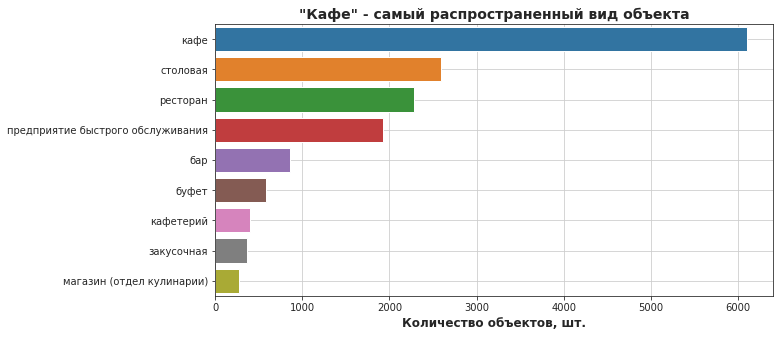

In [16]:
plt.figure(figsize=(10,5))
sns.barplot(x="id", y="object_type",  data=obj_type)
plt.title('"Кафе" - самый распространенный вид объекта',  fontsize=14, fontweight='bold')
plt.xlabel('Количество объектов, шт.', fontsize=12, fontweight='bold')
plt.ylabel('', fontsize=12)
plt.grid()
plt.show()

In [17]:
obj_type_num = df.groupby('object_type')['number'].mean().sort_values(ascending=False).reset_index()
obj_type_num

,object_type,number
0,столовая,130.246618
1,ресторан,96.834136
2,буфет,51.129915
3,бар,43.494159
4,кафе,39.716019
5,предприятие быстрого обслуживания,20.552262
6,кафетерий,9.123116
7,закусочная,7.608333
8,магазин (отдел кулинарии),5.589744


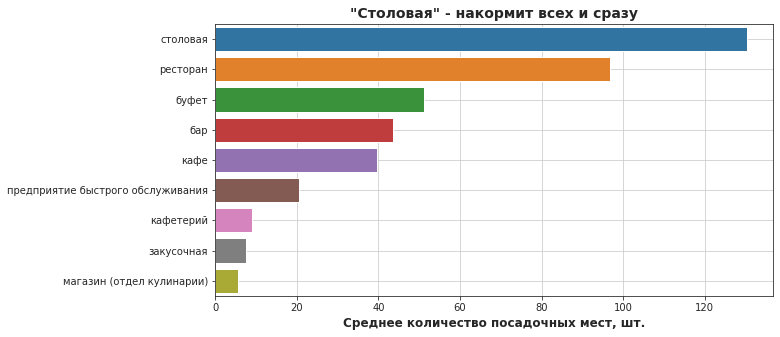

In [18]:
plt.figure(figsize=(10,5))
sns.barplot(x="number", y="object_type",  data=obj_type_num)
plt.title('"Столовая" - накормит всех и сразу',  fontsize=14, fontweight='bold')
plt.xlabel('Среднее количество посадочных мест, шт.', fontsize=12, fontweight='bold')
plt.ylabel('', fontsize=12)
plt.grid()
plt.show()

### Сетевой признак

In [19]:
net_type = df.groupby('chain')['id'].count().sort_values(ascending=False).reset_index()
net_type

,chain,id
0,нет,12398
1,да,2968


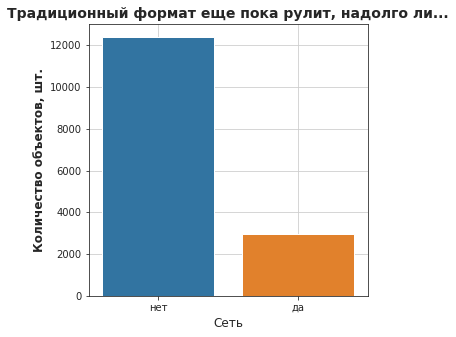

In [20]:
plt.figure(figsize=(5,5))

sns.barplot(y="id", x="chain",  data=net_type)
plt.title('Традиционный формат еще пока рулит, надолго ли...',  fontsize=14, fontweight='bold')
plt.xlabel('Сеть', fontsize=12)
plt.ylabel('Количество объектов, шт.', fontsize=12, fontweight='bold')
plt.grid()
plt.show()

#### Посмотрим картинку в разрезе вида объектов:

In [21]:
net_obj_type = df.groupby(['object_type', 'chain'])['id'].count().reset_index()

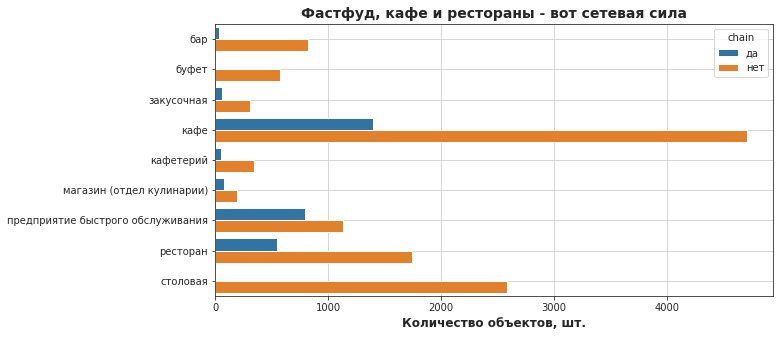

In [22]:
plt.figure(figsize=(10,5))
sns.barplot(y="object_type", x="id", hue="chain", data=net_obj_type) 
plt.title('Фастфуд, кафе и рестораны - вот сетевая сила',  fontsize=14, fontweight='bold')
plt.xlabel('Количество объектов, шт.', fontsize=12, fontweight='bold')
plt.ylabel('', fontsize=12)
plt.grid()
plt.show()

Для ответа на вопрос, какое количество заведений и посадочных мест характерны для средней сети, **расчитаем медианы количества и суммы посадочных мест**. Для исключения выбросов "сетью" будем считать сеть с 5 и более объектами(минимальное значение для локальной сетки)

In [23]:
df.query('chain == "да"').groupby('object_name')['number'].agg(['count', 'sum']).query('count >5').median()


count     11.0
sum      594.0
dtype: float64

И так: для сетей характерно **количество: более 10 объектов** и **среднее количество посадочных мест: 54**

[к содержанию...](#title)

<a name="by_geo"></a>
## Расположение и его влияние

1. Выделите в отдельный столбец информацию об улице из столбца address. **+**
2. Постройте график топ-10 улиц по количеству объектов общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы? **+**
3. Найдите число улиц с одним объектом общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы? **+**
4. Посмотрите на распределение количества посадочных мест для улиц с большим количеством объектов общественного питания. Какие закономерности можно выявить? **+**

### ТОП-10

#### Построим график топ-10 улиц по количеству объектов.

In [24]:
top10 = df.groupby('streetname')['id'].count().sort_values(ascending=False).head(10).reset_index()
top10

,streetname,id
0,проспект Мира,204
1,Профсоюзная улица,182
2,Ленинградский проспект,171
3,Пресненская набережная,167
4,Варшавское шоссе,164
5,Ленинский проспект,147
6,проспект Вернадского,132
7,Кутузовский проспект,114
8,Каширское шоссе,112
9,Кировоградская улица,110


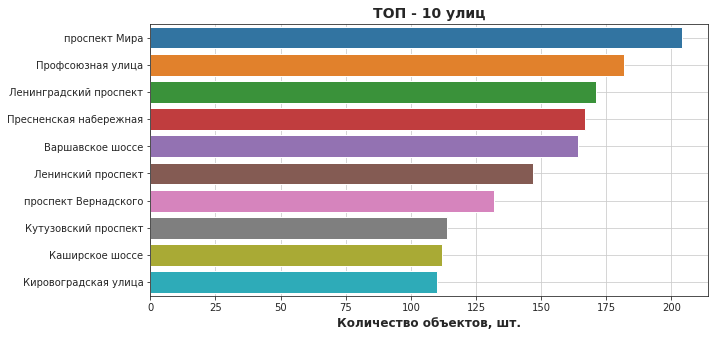

In [25]:
plt.figure(figsize=(10,5))
sns.barplot(y="streetname", x="id",data=top10) 
plt.title('ТОП - 10 улиц',  fontsize=14, fontweight='bold')
plt.xlabel('Количество объектов, шт.', fontsize=12, fontweight='bold')
plt.ylabel('', fontsize=12)
plt.grid()
plt.show()

#### Определим к каким районам они относятся:

In [26]:
top10area = top10.merge(rg, on='streetname', how='left').groupby(['okrug', 'area'])['streetname'].count().reset_index()
top10area

,okrug,area,streetname
0,ЗАО,Район Дорогомилово,1
1,ЗАО,Район Проспект Вернадского,2
2,ЗАО,Район Раменки,1
3,ЗАО,Район Тропарево-Никулино,2
4,ЗАО,Район Фили-Давыдково,1
5,САО,Район Аэропорт,1
6,САО,Район Беговой,1
7,САО,Район Сокол,1
8,САО,Хорошевский район,1
9,СВАО,Алексеевский район,1


#### Оценим распределение количества посадочных мест на улицах ТОП-10

#### Для начала "среднего" для улицы объекта:

In [27]:
top10.merge(df.groupby('streetname')['number'].mean().reset_index(), on='streetname', how='left').mean()

id        150.300000
number     59.050776
dtype: float64

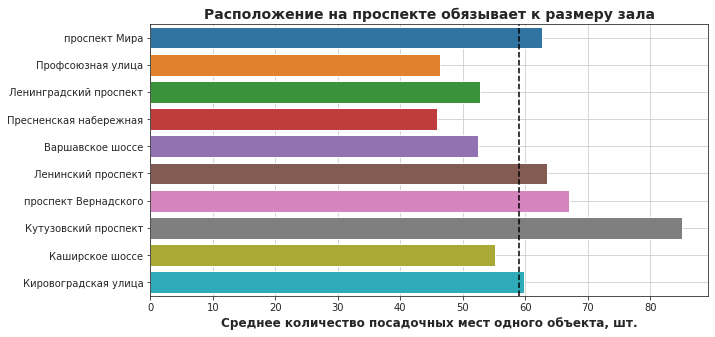

In [28]:
plt.figure(figsize=(10,5))
sns.barplot(y="streetname", x="number", data=top10.merge(df.groupby('streetname')['number']
                                                       .mean()
                                                       .reset_index(), on='streetname', how='left')) 
plt.title('Расположение на проспекте обязывает к размеру зала',  fontsize=14, fontweight='bold')
plt.xlabel('Среднее количество посадочных мест одного объекта, шт.', fontsize=12, fontweight='bold')
plt.ylabel('', fontsize=12)
plt.grid()
plt.axvline(x=59, color='black', linestyle='--') 
plt.show()

#### А теперь общего для улицы числа посадочных мест:

In [29]:
top10.merge(df.groupby('streetname')['number'].sum().reset_index(), on='streetname', how='left')

,streetname,id,number
0,проспект Мира,204,12790
1,Профсоюзная улица,182,8447
2,Ленинградский проспект,171,9010
3,Пресненская набережная,167,7656
4,Варшавское шоссе,164,8606
5,Ленинский проспект,147,9330
6,проспект Вернадского,132,8840
7,Кутузовский проспект,114,9697
8,Каширское шоссе,112,6171
9,Кировоградская улица,110,6577


In [30]:
top10.merge(df.groupby('streetname')['number'].sum().reset_index(), on='streetname', how='left').mean()

id         150.3
number    8712.4
dtype: float64

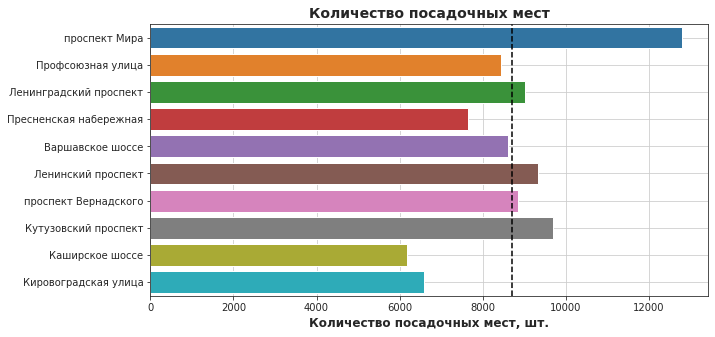

In [31]:
plt.figure(figsize=(10,5))
sns.barplot(y="streetname", x="number", data=top10.merge(df.groupby('streetname')['number']
                                                       .sum()
                                                       .reset_index(), on='streetname', how='left')) 
plt.title('Количество посадочных мест',  fontsize=14, fontweight='bold')
plt.xlabel('Количество посадочных мест, шт.', fontsize=12, fontweight='bold')
plt.ylabel('', fontsize=12)
plt.grid()
plt.axvline(x=8712, color='black', linestyle='--') 
plt.show()

#### Вывод по ТОП-10
Наибольшее количество посадочных мест на проспекте Мира, минимальное на Кировоградской и Каширском шоссе. При этом самые крупные по количеству мест заведения находятся на Кутузовском проспекте и вообще ранжир по размеру зала возглавляют именно проспекты.

### Улицы с одним объектом

In [32]:
lose = df.groupby('streetname')['id'].count().reset_index()
lose = lose.query('id == 1').reset_index()
lose = lose['streetname'].reset_index()
lose = lose.merge(rg, on='streetname', how='left')
lose

,index,streetname,areaid,okrug,area
0,0,1-й Балтийский переулок,54.0,САО,Район Аэропорт
1,1,1-й Басманный переулок,13.0,ЦАО,Басманный район
2,1,1-й Басманный переулок,15.0,ЦАО,Красносельский район
3,2,1-й Ботанический проезд,82.0,СВАО,Район Свиблово
4,3,1-й Вешняковский проезд,120.0,ЮВАО,Рязанский район
...,...,...,...,...,...
760,717,улица Шеногина,92.0,СЗАО,Район Хорошево-Мневники
761,718,улица Шумилова,113.0,ЮВАО,Район Кузьминки
762,719,улица Шумкина,26.0,ВАО,Район Сокольники
763,720,улица Щорса,46.0,ЗАО,Район Солнцево


In [33]:
lose_area = lose.groupby(['okrug', 'area'])['streetname'].count().reset_index()
lose_area

,okrug,area,streetname
0,ВАО,Район Богородское,9
1,ВАО,Район Восточное Измайлово,2
2,ВАО,Район Восточный,2
3,ВАО,Район Гольяново,4
4,ВАО,Район Ивановское,1
...,...,...,...
96,ЮЗАО,Район Котловка,2
97,ЮЗАО,Район Северное Бутово,2
98,ЮЗАО,Район Черемушки,2
99,ЮЗАО,Район Южное Бутово,8


In [34]:
lose_area['okrug'].unique()

array(['ВАО', 'ЗАО', 'Зеленоград', 'САО', 'СВАО', 'СЗАО', 'ЦАО', 'ЮАО',
       'ЮВАО', 'ЮЗАО'], dtype=object)

In [35]:
top10area['okrug'].unique()

array(['ЗАО', 'САО', 'СВАО', 'ЦАО', 'ЮАО', 'ЮЗАО'], dtype=object)

### Вывод по разделу
Наибольшее количество посадочных мест на проспекте Мира, минимальное на Кировоградской и Каширском шоссе. При этом самые крупные по количеству мест заведения находятся на Кутузовском проспекте и вообще ранжир по размеру зала возглавляют именно проспекты.

Определим как наиболее перспективные и соответствующие по количеству посадочных мест улицы: Профсоюзную, Ленинградский проспект и Пресненскую набережную. Поиск помещения будем вести во включающих эти улицы районах.

In [36]:
top10.query('streetname == "Профсоюзная улица"|streetname == "Ленинградский проспект"|streetname == "Пресненская набережная"').merge(rg, on='streetname', how='left').groupby(['okrug', 'area'])['streetname'].count()

okrug  area               
САО    Район Аэропорт         1
       Район Беговой          1
       Район Сокол            1
       Хорошевский район      1
ЦАО    Пресненский район      1
ЮЗАО   Академический район    1
       Обручевский район      1
       Район Коньково         1
       Район Теплый Стан      1
       Район Черемушки        1
       Район Ясенево          1
Name: streetname, dtype: int64

[к содержанию...](#title)

<a name="general"></a>
# Общий вывод

Выбранный для нашего проекта **вид заведения - «кафе»**, является самым массовым на рынке, что говорит о его востребованности среди потребителя и доступности для предпринимателя.

Лидером по числу посадочных мест является столовая, будем рассматривать её как один из вариантов развития, но на текущий момент нас интересует: **«Кафе» = 40 посадочных мест**. 

В сфере общепита «традиция» пока преобладает над сетью, но выбранный нами вид заведения и концепт **располагают к развитию сети.** К тому же о потенциале данного подхода говорит и рынок.

Наибольшее количество посадочных мест на проспекте Мира, минимальное на Кировоградской и Каширском шоссе. 
	
При этом самые крупные по количеству мест заведения находятся на Кутузовском проспекте и вообще ранжир по размеру зала возглавляют именно проспекты.    

Определим как наиболее перспективные и соответствующие по количеству посадочных мест улицы: Профсоюзную, Ленинградский проспект и Пресненскую набережную. 

**Поиск помещения** будем вести во включающих эти улицы районах:
- Район Аэропорт
- Район Беговой
- Район Сокол
- Хорошевский район
- Пресненский район
- Академический район
- Обручевский район
- Район Коньково
- Район Теплый Стан
- Район Черемушки
- Район Ясенево   

**Файл презентации**
https://drive.google.com/file/d/1-VyLiHU3gAEJYceck7R2YhGwxhslRdD8/view?usp=sharing

[к содержанию...](#title)